In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from PIL import Image

In [4]:
df_loc = '/media/mike/beta/decals/results/classifications_2019_10_03.csv'
df = pd.read_csv(df_loc)

### How many unique galaxies are there?

In [14]:
def count_unique(df):
    print('{} unique galaxies in {} subjects ({:.3f})'.format(len(df['iauname'].unique()), len(df), len(df['iauname'].unique())/len(df)))

In [15]:
count_unique(df)

86957 unique galaxies in 105074 subjects (0.828)


Okay, so that's not great. What's going on?

## Summary

- 4000 repeats from pre-active learning galaxies (15%). 3000 from an accidental re-upload of the first 3000, and 1000 from an unknown mistake.
- 7000 repeats from active learning (50%!). I've clearly messed up the selection of galaxies to upload somehow - they should be filtered to only include galaxies not yet labelled.
- 5000 repeats from random galaxies, because I accidentally uploaded the same batch on April 12th and April 16th 2019.

Total: 19,000. All repeats accounted for.

This is way too many repeats to be efficient. How can we fix this for new uploads?

### Work needed

- Upload routine (shared for random and active) should refuse to upload galaxies which are already labelled. To do this, get the latest classifications before running any uploads.
- Add checks that master catalog has no duplicate iaunames
- If no duplicate iaunames, debug the active learning loop to see hpw repeat uploads on the same day are possible. Should be a ranked list, and is unit tested!

## Investigation

How many subjects have each retirement limit?

In [7]:
pd.isnull(df['retirement_limit']).sum()

53970

In [9]:
df['retirement_limit'].value_counts()

3.0     34781
40.0    15871
10.0      452
Name: retirement_limit, dtype: int64

### Looking within pre-active-learning galaxies (no retirement limit metadata)

Mostly down to two errors. Once, uploading the first 3k galaxies twice (probably a wrong button). Once, 881 previously-uploaded galaxies were re-uploaded as part of a new upload - not sure how.

In [16]:
pre_active =  df[pd.isnull(df['retirement_limit'])]
count_unique(pre_active)

49886 unique galaxies in 53970 subjects (0.924)


In [27]:
def count_repeats(df):
    return df['iauname'].value_counts().value_counts()

In [28]:
count_repeats(pre_active)

1    45825
2     4038
3       23
Name: iauname, dtype: int64

In [73]:
def show_uploads_over_time(df):
    df_dup = df[df['iauname'].duplicated(keep=False)]
    dup_agg = df_dup.groupby('upload_date').agg('count')
    all_agg = df.groupby('upload_date').agg('count')
    
    fig, axes = plt.subplots(nrows=2, figsize=(20, 14))
    
    axes[0].scatter(dup_agg.index, dup_agg['subject_id'], label='dup')
    axes[0].scatter(all_agg.index, all_agg['subject_id'], label='all', alpha=0.5)
    axes[0].legend()
    axes[0].set_ylabel('Subjects')
    axes[0].set_ylim([0, None])
    
    axes[1].scatter(dup_agg.index, dup_agg['subject_id'] / all_agg['subject_id'])  # assumes same index
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel('Fraction of subjects which are ever uploaded more than once')
    

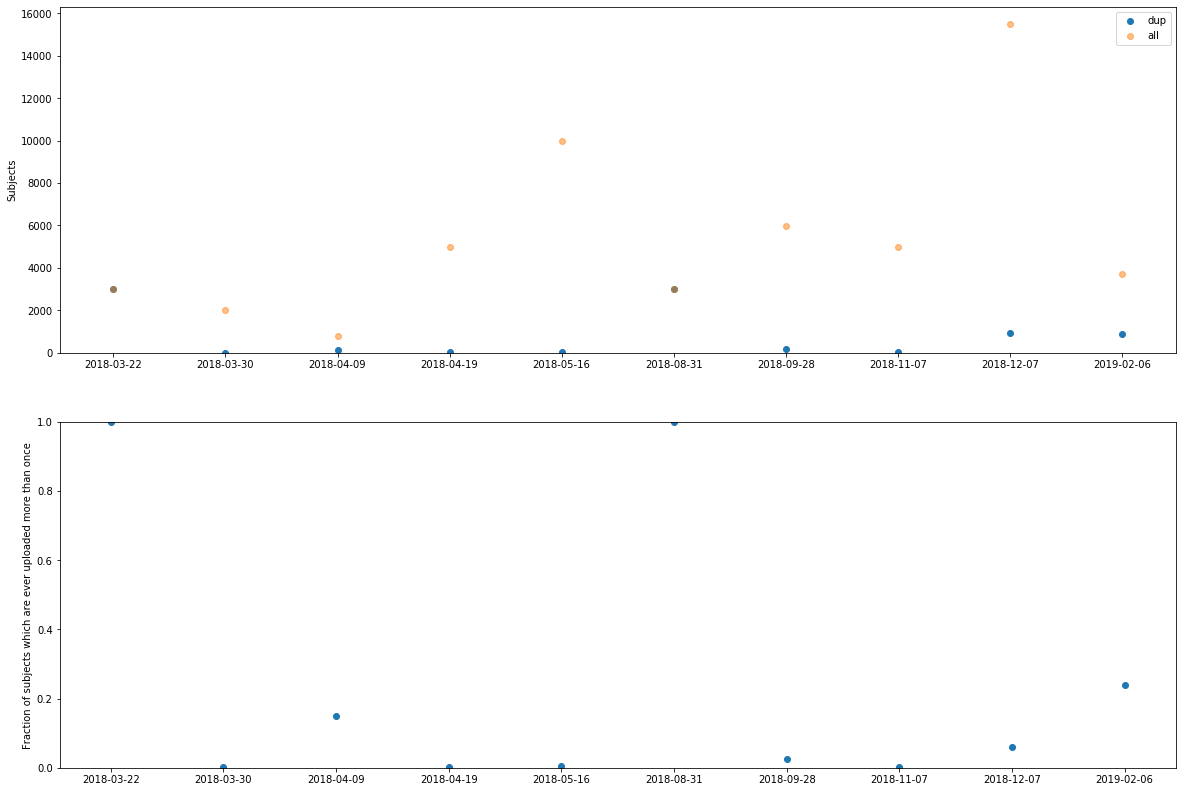

In [74]:
show_uploads_over_time(pre_active)

In [34]:
def group_by_duplicate_dates(df, degree=2):
    return df.sort_values('upload_date').groupby('iauname').agg({'upload_date': lambda x: json.dumps([y for y in x[:degree]])}).reset_index()

In [35]:
grouped_dates = group_by_duplicate_dates(pre_active)

In [36]:
grouped_dates['upload_date'].value_counts()

["2018-12-07"]                  14590
["2018-05-16"]                   9955
["2018-09-28"]                   5820
["2018-04-19"]                   4990
["2018-11-07"]                   4987
["2018-03-22", "2018-08-31"]     2992
["2019-02-06"]                   2817
["2018-03-30"]                   1995
["2018-12-07", "2019-02-06"]      881
["2018-04-09"]                    671
["2018-04-09", "2018-09-28"]       66
["2018-05-16", "2018-09-28"]       45
["2018-04-09", "2018-12-07"]       29
["2018-04-09", "2018-11-07"]       13
["2018-09-28", "2018-09-28"]       11
["2018-04-19", "2018-09-28"]       10
["2018-03-22", "2018-04-09"]        8
["2018-03-30", "2018-09-28"]        3
["2018-03-30", "2018-04-09"]        2
["2018-04-09", "2019-02-06"]        1
Name: upload_date, dtype: int64

On August 31st, 2018, I uploaded exactly the same set of 2992 galaxies as I did at launch (but after Nair). These are the first 3k galaxies. They are incorrectly listed as 'new' in my notes. Probably I typed the wrong command...
https://github.com/zooniverse/galaxy-zoo-panoptes/wiki/DECALS-DR5-Subject-Set-History

In [37]:
pre_active['upload_date'].value_counts()

2018-12-07    15500
2018-05-16    10000
2018-09-28     5977
2018-04-19     5000
2018-11-07     5000
2019-02-06     3703
2018-03-22     3000
2018-08-31     3000
2018-03-30     2000
2018-04-09      790
Name: upload_date, dtype: int64

In [38]:
(pre_active['upload_date'] == '2019-02-06').sum()

3703

In [39]:
pre_active['iauname'].duplicated(keep=False).sum()

8145

On February 6th 2019, as part of a batch of 3703 galaxies (strange number), I accidentally uploaded 881 galaxies that had already been uploaded on six months earlier on 2018-05-16. I'm not sure how this happened.

### Looking within active learning selected galaxies (retirement = 40)

Somehow, active learning is not correctly filtering out galaxies which already have a label, and hence is consistently re-uploading some of the same galaxies

In [40]:
ret40 = df.query('retirement_limit == 40')
count_unique(ret40)
# half (!) of active learning galaxies were uploaded once
# this is a big problem - how can I be uploading the same galaxies?

7237 unique galaxies in 15871 subjects (0.456)


In [41]:
ret40_dup = ret40[ret40['iauname'].duplicated()]

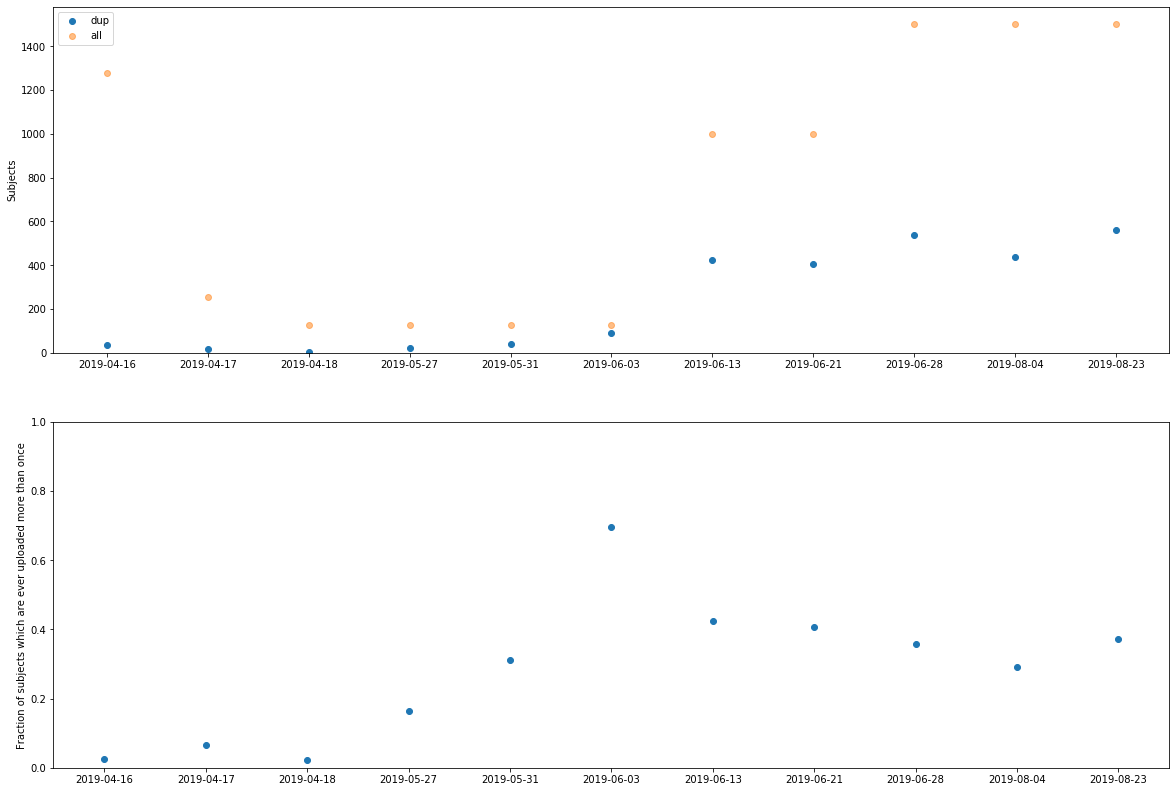

In [75]:
show_uploads_over_time(ret40)

In [77]:
grouped_dates = group_by_duplicate_dates(ret40)

In [78]:
grouped_dates['upload_date'].value_counts()

["2019-04-16"]                  1246
["2019-08-04"]                  1064
["2019-06-28"]                   962
["2019-08-23"]                   940
["2019-06-21"]                   594
["2019-06-13"]                   577
["2019-06-28", "2019-08-23"]     300
["2019-04-17"]                   239
["2019-06-13", "2019-06-28"]     197
["2019-06-13", "2019-08-04"]     195
["2019-06-21", "2019-08-04"]     189
["2019-06-21", "2019-08-23"]     187
["2019-04-18"]                   125
["2019-05-27"]                   107
["2019-05-31"]                    88
["2019-06-03"]                    39
["2019-06-03", "2019-06-28"]      35
["2019-06-03", "2019-08-23"]      28
["2019-06-03", "2019-06-21"]      25
["2019-05-31", "2019-08-04"]      20
["2019-05-31", "2019-06-13"]      19
["2019-04-16", "2019-04-17"]      11
["2019-05-27", "2019-06-13"]       9
["2019-05-27", "2019-08-04"]       8
["2019-04-16", "2019-06-28"]       6
["2019-04-16", "2019-08-23"]       4
["2019-04-16", "2019-08-04"]       4
[

Active learning is often requesting labels for the same galaxies *on the same day*. 

For this to happen, either the subject_id list to upload is not unique or the master catalog has duplicate iaunames.

### Looking within galaxies with retirement = 3

Conclusion: I once accidentally uploaded (mostly) the same batch of galaxies twice, causing 4000/8000 duplicates

In [46]:
ret3 = df.query('retirement_limit == 3')
count_unique(ret3)
# 87% of random galaxies were uploaded only once as random-selected

30371 unique galaxies in 34781 subjects (0.873)


In [47]:
ret3_dup = ret3[ret3['iauname'].duplicated()]
dup_agg = ret3_dup.groupby('upload_date').agg('count')
# fig, ax= plt.subplots(figsize=(20, 5))
# ax.plot(dup_agg['subject_id'])
dup_agg['subject_id'].value_counts()
# for galaxies which have an upload date recorded, I accidentally uploaded the two batches of galaxies on April 12th and April 16th which (mostly) overlapped

2210    1
2200    1
Name: subject_id, dtype: int64

In [48]:
april_12th = ret3[ret3['upload_date'] == '2019-04-12']
april_16th = ret3[ret3['upload_date'] == '2019-04-16']

In [49]:
len(april_12th), len(april_16th)

(5314, 5000)

In [50]:
april_12th['iauname'].isin(april_16th['iauname']).value_counts()

True     4410
False     904
Name: iauname, dtype: int64

In [51]:
april_12th['iauname'].value_counts().max()

1

In [52]:
april_16th['iauname'].value_counts().max()

1

In [54]:
ret3_no_upload = ret3[pd.isnull(ret3['upload_date'])]
len(ret3_no_upload)  # every galaxy with retirement=3 has an upload date

0

### Looking at overlap between random (ret3) and active (ret40) subjects

444 galaxies have been uploaded as both random and active-learning selected, which is not ideal but a lot less of a problem than the active learning repeats.

In [62]:
ret3_galaxies = set(ret3['iauname'].unique())
ret40_galaxies = set(ret40['iauname'].unique())

In [65]:
len(ret3_galaxies.intersection(ret40_galaxies))

444

In [66]:
len(ret3), len(ret40)

(34781, 15871)